In [1]:
!pip install pandas matplotlib seaborn --quiet


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")


In [3]:
df = pd.read_csv('/content/synthetic_covid19_data.csv', parse_dates=['date'], low_memory=False)
df.head()


,date,continent,location,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,positive_rate,...,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence
0,2021-11-19,Asia,India,6423388,2490,107051,323,60016385,7386,0.904377,...,69.259331,1241418161,67.394702,49.883751,8.649395,16.052063,44313.199955,20.827286,177.832655,16.296474
1,2021-09-12,North America,Russia,6550634,6980,481184,697,28666409,6862,0.525850,...,7.185287,114516392,694.409929,30.126823,8.957854,4.423022,8196.945011,20.478579,470.991420,8.579170
2,2020-04-20,Europe,Canada,4304572,9134,15116,325,80352550,40108,0.791575,...,14.823246,1152898402,784.464729,22.648063,9.336778,18.776372,52607.000057,11.924664,415.880908,14.989789
3,2022-10-16,Asia,Germany,2234489,7661,20045,624,89212990,91788,0.115291,...,70.007502,1342525124,403.467508,42.951109,5.321894,10.526520,23297.985037,4.591400,643.510444,18.084096
4,2021-05-15,Europe,USA,9958614,1724,419543,824,5364240,75023,0.927643,...,28.972334,744943966,182.869692,26.414731,19.321761,15.889173,56126.828895,5.431330,451.846790,5.971409


In [4]:
df.info()
df.describe(include='all')
df.isnull().sum().sort_values(ascending=False).head(20)
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     3000 non-null   datetime64[ns]
 1   continent                3000 non-null   object        
 2   location                 3000 non-null   object        
 3   total_cases              3000 non-null   int64         
 4   new_cases                3000 non-null   int64         
 5   total_deaths             3000 non-null   int64         
 6   new_deaths               3000 non-null   int64         
 7   total_tests              3000 non-null   int64         
 8   new_tests                3000 non-null   int64         
 9   positive_rate            3000 non-null   float64       
 10  tests_per_case           3000 non-null   float64       
 11  total_vaccinations       3000 non-null   int64         
 12  people_vaccinated        3000 non-

np.int64(0)

In [5]:
cols = ['date','location','continent','total_cases','new_cases','total_deaths','population']
if 'total_recovered' in df.columns:
    cols.append('total_recovered')

df = df[cols].copy()

df = df.dropna(subset=['date','location'])

num_cols = ['total_cases','new_cases','total_deaths','total_recovered'] if 'total_recovered' in df.columns else ['total_cases','new_cases','total_deaths']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

for c in ['new_cases']:
    if c in df.columns:
        df.loc[df[c] < 0, c] = 0

df.sort_values(['location','date'], inplace=True)
df.reset_index(drop=True, inplace=True)


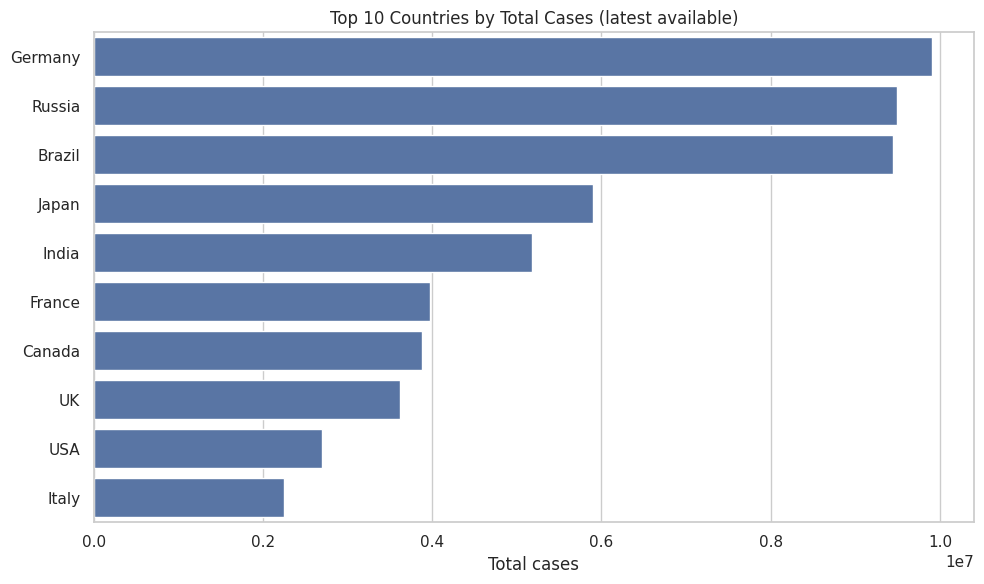

In [6]:
latest = df.sort_values('date').groupby('location').tail(1)
top10 = latest.nlargest(10, 'total_cases')[['location','total_cases']]
plt.figure(figsize=(10,6))
sns.barplot(data=top10, x='total_cases', y='location')
plt.title('Top 10 Countries by Total Cases (latest available)')
plt.xlabel('Total cases')
plt.ylabel('')
plt.tight_layout()
plt.show()


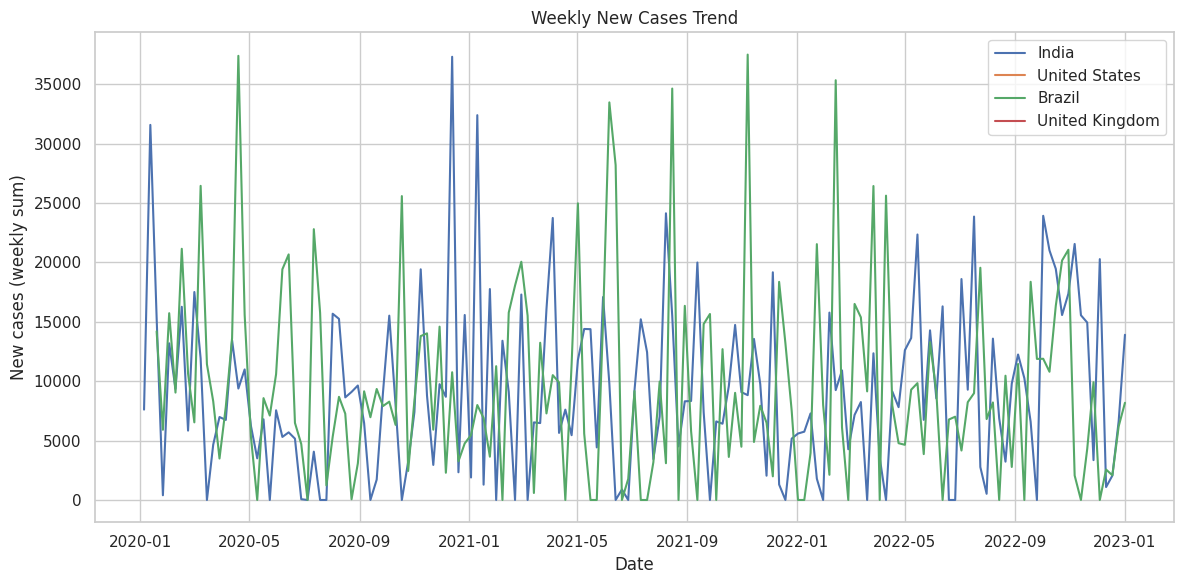

In [7]:
countries = ['India','United States','Brazil','United Kingdom']  # change as needed
sel = df[df['location'].isin(countries)].copy()
plt.figure(figsize=(12,6))
for country in countries:
    temp = sel[sel['location'] == country].set_index('date').resample('W')['new_cases'].sum()
    plt.plot(temp.index, temp.values, label=country)
plt.legend()
plt.title('Weekly New Cases Trend')
plt.xlabel('Date')
plt.ylabel('New cases (weekly sum)')
plt.tight_layout()
plt.show()


In [8]:
if 'total_recovered' in df.columns:
    latest = df.sort_values('date').groupby('location').tail(1)
    sample = latest.nlargest(15, 'total_deaths')[['location','total_deaths','total_recovered']].set_index('location')
    sample.plot(kind='bar', figsize=(12,6))
    plt.title('Total Deaths vs Total Recovered (Top 15 by deaths)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("Dataset has no 'total_recovered' column — skip this chart or find a dataset with recoveries.")


Dataset has no 'total_recovered' column — skip this chart or find a dataset with recoveries.


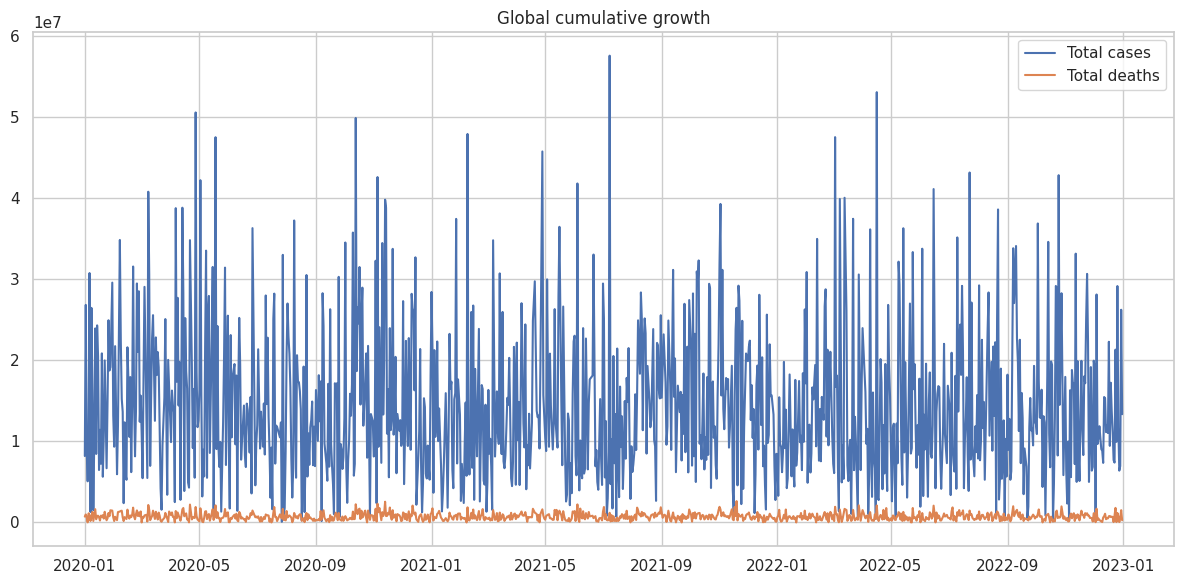

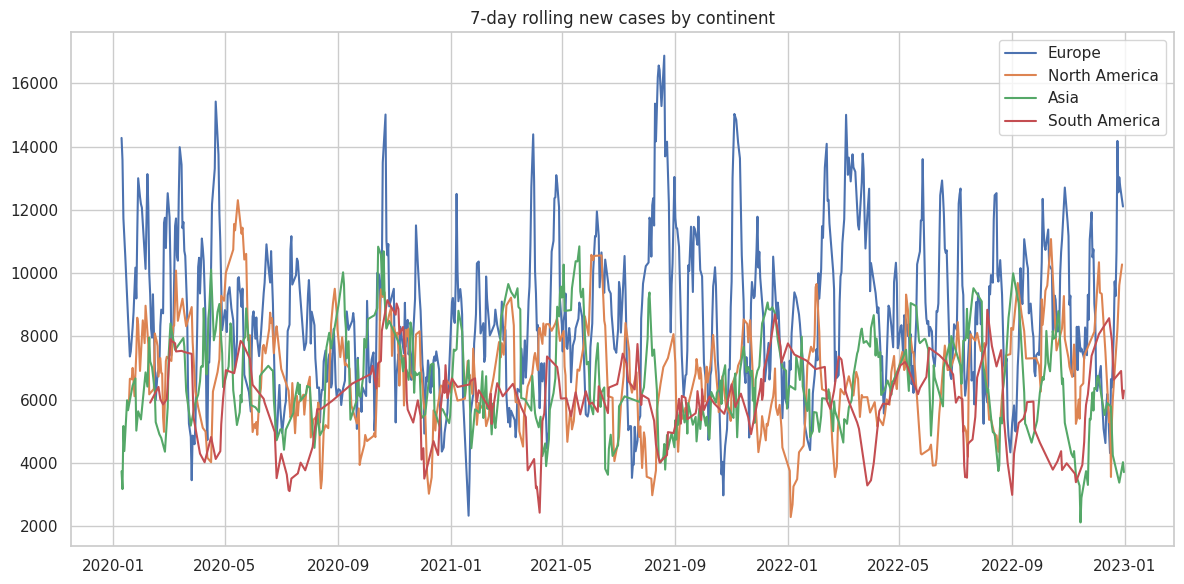

In [9]:
global_daily = df.groupby('date')[['new_cases','total_cases','total_deaths']].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(global_daily['date'], global_daily['total_cases'], label='Total cases')
plt.plot(global_daily['date'], global_daily['total_deaths'], label='Total deaths')
plt.title('Global cumulative growth')
plt.legend()
plt.tight_layout()
plt.show()

cont_daily = df.groupby(['date','continent'])['new_cases'].sum().reset_index()
plt.figure(figsize=(12,6))
for cont in cont_daily['continent'].dropna().unique():
    temp = cont_daily[cont_daily['continent']==cont].set_index('date')['new_cases'].rolling(7).mean()
    plt.plot(temp.index, temp.values, label=cont)
plt.title('7-day rolling new cases by continent')
plt.legend()
plt.tight_layout()
plt.show()


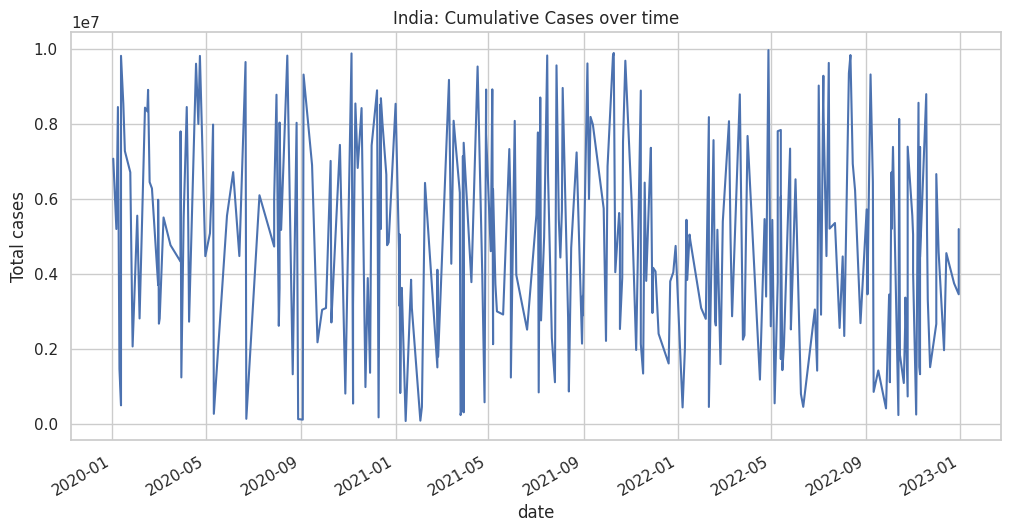

In [10]:
india = df[df['location']=='India'].set_index('date').sort_index()
india['total_cases'].plot(figsize=(12,6), title="India: Cumulative Cases over time")
plt.ylabel('Total cases')
plt.show()


In [11]:
latest = df.sort_values('date').groupby('location').tail(1).copy()
latest['death_rate_percent'] = (latest['total_deaths'] / latest['total_cases']) * 100

latest['death_rate_percent'] = latest['death_rate_percent'].replace([np.inf, -np.inf], np.nan)
latest[['location','total_cases','total_deaths','death_rate_percent']].sort_values('death_rate_percent', ascending=False).head(10)


,location,total_cases,total_deaths,death_rate_percent
1788,Italy,2253722,485319,21.534111
2999,USA,2704999,407561,15.066956
1488,India,5184502,351136,6.772801
911,France,3970001,261849,6.595691
2688,UK,3622138,188337,5.199609
618,Canada,3878450,141707,3.653702
297,Brazil,9451337,285291,3.018525
1198,Germany,9907771,144615,1.459612
2405,Russia,9490536,135996,1.432964
2103,Japan,5895544,23004,0.390193
